In [1]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/global.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


In [3]:
# Some column subsets that may be useful
# Passenger characteristics:
passenger_cols = ['AlienMasterID', 'Status', 'Sex', 'Convictions', 'GangMember',
       'ClassLvl', 'Age', 'MissionNumber', 'PULOC', 'DropLoc',
       'StrikeFromList', 'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship',
       'Juvenile', 'MissionWeek', 'MissionQuarter', 'MissionYear',
       'MissionMonth', 'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag',
       'MissionID', 'MissionDate']
# Airport metadata:
airport_cols = ['air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'air_LatitudeDecimalDegrees',
       'air_LongitudeDecimalDegrees', 'air2_LatitudeDecimalDegrees',
       'air2_LongitudeDecimalDegrees']
# Pickup location ('PULOC') airport metadata:
airport1_cols = ['air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country','air_LatitudeDecimalDegrees', 'air_LongitudeDecimalDegrees']
# Dropoff location ('DropLoc') airport metadata:
airport2_cols = ['air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'air2_LatitudeDecimalDegrees',
       'air2_LongitudeDecimalDegrees']

# Global variables

Here we calculate top-level data on the global scope of the ICE Air dataset. We assert that there are no duplicate records, and that each record has a unique non-null `AlienMasterID` value.

In [4]:
pre_drop = len(df)
df = df.drop_duplicates()
post_drop = len(df)
assert pre_drop == post_drop

assert sum(df['AlienMasterID'].isnull()) == 0
assert len(df) == len(set(df['AlienMasterID']))

print(f"Unique AlienMasterID values: {len(set(df['AlienMasterID']))}")
      
# Span of 'AlienMasterID' values is greater than number of unique values, so some must be skipped.
print(f"Range of AlienMasterID values: {df['AlienMasterID'].max() - df['AlienMasterID'].min()}")

Unique AlienMasterID values: 1732625
Range of AlienMasterID values: 2042246


No missing values in `MissionID` and `MissionNumber` fields. 

In [5]:
unique_MissionID = len(set(df['MissionID']))
assert sum(df['MissionID'].isnull()) == 0
print(f"Unique MissionID values: {unique_MissionID}")

unique_MissionNumber = len(set(df['MissionNumber']))
assert sum(df['MissionNumber'].isnull()) == 0
print(f"Unique MissionNumber values: {unique_MissionNumber}")

Unique MissionID values: 14961
Unique MissionNumber values: 14961


We finda one to one relationship of `MissionID` to `MissionNumber`. These fields seem to be equivalent and non-hierarchical. Ordering does not affect calculations.

In [6]:
assert sum(df.groupby(['MissionID'])['MissionNumber'].nunique() > 1) == 0
assert sum(df.groupby(['MissionNumber'])['MissionID'].nunique() > 1) == 0

missions = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'PULOC', 'DropLoc'])
missions_alt = df.groupby(['MissionDate', 'MissionNumber', 'MissionID',  'PULOC', 'DropLoc'])
missions_alt_2 = df.groupby(['MissionNumber', 'MissionID', 'MissionDate',  'PULOC', 'DropLoc'])
assert len(missions) == len(missions_alt)
assert len(missions) == len(missions_alt_2)
del missions_alt, missions_alt_2
mission_segments = len(missions)
print(f"{mission_segments} unique mission segments, grouped by mission and date.")

41210 unique mission segments, grouped by mission and date.


In [7]:
# MissionID and MissionNumber values do not have a clear logic.
# MissionNumber does not correspond to flight numbers as asserted by ARTS data dictionary

print(f"Lowest MissionID value: {df['MissionID'].min()}")
print(f"Highest MissionID value: {df['MissionID'].max()}")
print()
print(f"Lowest MissionNumber value: {df['MissionNumber'].min()}")
print(f"Highest MissionNumber value: {df['MissionNumber'].max()}")

Lowest MissionID value: 105
Highest MissionID value: 47456

Lowest MissionNumber value: 110001
Highest MissionNumber value: 190356


In [8]:
missions['AlienMasterID'].nunique().max()

270

In [9]:
missions['AlienMasterID'].nunique().mean()

42.04380004853191

In [10]:
df.groupby('MissionID')['AlienMasterID'].nunique().median()

119.0

The following is a glimpse of flight segments from the first day in the dataset, showing how flight segments are grouped by `MissionID`/`MissionNumber`. We cannot assume that a unique combination of `PULOC` and `DropLoc` on a given mission represents a specific flight path, only the pickup and dropoff locations of each passenger. Missions can include a combination of both removal (`R`) and transfer (`T`) flights.

According to a [2015 audit of ICE Air Operations by the Department of Homeland Security Office of Inspector General](https://www.oig.dhs.gov/assets/Mgmt/2015/OIG_15-57_Apr15.pdf), each `MissionID`/`MissionNumber` represents a single flight, possibly with multiple pickup and dropoff stops on its itinerary. Reconstructing the exact flight itinerary from this data may not be possible, given that there are no timestamp values below the day level, nor any other explicit indications of consecutive flight segments, other than the original ordering of the records.

In [11]:
missions_rt = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'R-T', 'PULOC', 'DropLoc'])
missions_rt['AlienMasterID'].nunique().head(15)

MissionDate  MissionID  MissionNumber  R-T  PULOC  DropLoc
2010-10-01   105        110005         T    KMDT   KAEX       122
             106        110006         R    KHRL   MGGT        67
                                            KSAT   MGGT        37
             107        110007         R    KAEX   MHLM        97
             108        110008         R    KMCI   KHRL        35
                                            KORD   KHRL        63
                                       T    KMCI   KAEX        10
                                            KORD   KAEX        25
             131        110002         R    KBFL   KSAN        13
                                            KOAK   KSAN        43
                                       T    KBFL   KIWA         3
                                                   KSAN         8
                                            KOAK   KIWA        13
                                                   KSAN         5
                 

In [12]:
earliest_record = df['MissionDate'].min()
print(f'Earliest record: {earliest_record.date()}')
latest_record = df['MissionDate'].max()
print(f'Earliest record: {latest_record.date()}')

Earliest record: 2010-10-01
Earliest record: 2018-12-05


In [13]:
number_of_pickup_airports = len(set(df['PULOC'].dropna()))
number_of_dropoff_airports = len(set(df['DropLoc'].dropna()))
total_airports = len(set(df['PULOC']).union(set(df['DropLoc'])))
print(f'Number of pickup airports: {number_of_pickup_airports}')
print(f'Number of dropoff airports: {number_of_dropoff_airports}')
print(f'Total airports: {total_airports}')

Number of pickup airports: 81
Number of dropoff airports: 205
Total airports: 222


In [14]:
pickup_countries = set(df['air_Country'].dropna())
dropoff_countries = set(df['air2_Country'].dropna())
total_countries = len(set(df['air_Country']).union(set(df['air2_Country'])))
print(f'Number of pickup countries: {len(pickup_countries)}')
print(f'Number of dropoff countries: {len(dropoff_countries)}')
print(f'Total countries: {total_countries}')

Number of pickup countries: 10
Number of dropoff countries: 119
Total countries: 119


In [15]:
usa_pu = set(df.loc[df['air_Country'] == 'USA']['PULOC'].dropna())
usa_drop = set(df.loc[df['air2_Country'] == 'USA']['DropLoc'].dropna())
foreign_pu = set(df.loc[df['air_Country'] != 'USA']['PULOC'].dropna())
foreign_drop = set(df.loc[df['air2_Country'] != 'USA']['DropLoc'].dropna())

In [16]:
print(f'Total US airports: {len(usa_pu.union(usa_drop))}')

Total US airports: 88


In [17]:
print(f'Total international airports: {len(foreign_pu.union(foreign_drop))}')

Total international airports: 134


## ICE Air network expansion

The number of unique pickup and dropoff airports represented in the dataset per year can be interpreted as a metric for the expansion of the ICE Air network over time.

In [18]:
assert sum(df['DropLoc'].isnull()) == 0
assert sum(df['PULOC'].isnull()) == 0

droplocs_per_fy = df.resample('AS-OCT', on='MissionDate')['DropLoc']
pulocs_per_fy = df.resample('AS-OCT', on='MissionDate')['PULOC']

drop_countries_per_fy = df.resample('AS-OCT', on='MissionDate')['air2_Country']
pu_countries_per_fy = df.resample('AS-OCT', on='MissionDate')['air_Country']
unique_droplocs = droplocs_per_fy.nunique()
unique_pulocs = pulocs_per_fy.nunique()
unique_countries = drop_countries_per_fy.nunique()

expansion = pd.DataFrame({'Unique Pickup Airports': unique_pulocs,
                          'Unique Dropoff Airports': unique_droplocs,
                          'Unique Destination Countries': unique_countries})
expansion.index = expansion.index.year + 1
expansion.index.name = 'FY'
expansion.to_csv('../output/iceair-expansion.csv')

In [19]:
expansion

,Unique Pickup Airports,Unique Dropoff Airports,Unique Destination Countries
FY,,,
2011,41,69,35
2012,44,78,42
2013,45,48,16
2014,41,62,20
2015,36,60,32
2016,39,87,54
2017,40,85,49
2018,41,108,69
2019,31,52,23


# Most common pickup, dropoff airports

By unique `AlienMasterID` values (number of passengers):

In [20]:
# Passengers picked up:
df.drop_duplicates('AlienMasterID')['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239896
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196139
El Paso International Airport                           136127
Valley International Airport                            124994
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

In [21]:
# Passengers dropped off:
df.drop_duplicates('AlienMasterID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       326875
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148679
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87186
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62942
Name: air2_AirportName, dtype: int64

By unique `MissionID` values (number of flights):

In [22]:
# Departing flights:
df.groupby('air_AirportName')['MissionID'].nunique().sort_values(ascending=False).head(10)

air_AirportName
Alexandria International Airport                        4074
Phoenix-Mesa-Gateway Airport                            3856
Brownsville South Padre Island International Airport    2434
El Paso International Airport                           2315
San Antonio International Airport                       1858
Valley International Airport                            1508
Miami International Airport                             1454
Columbus Metropolitan Airport                           1140
San Diego International Airport                         1009
Metropolitan Oakland International Airport               970
Name: MissionID, dtype: int64

In [23]:
# Arriving flights:
df.groupby('air2_AirportName')['MissionID'].nunique().sort_values(ascending=False).head(10)

air2_AirportName
Alexandria International Airport                        3033
La Aurora Airport                                       3018
Phoenix-Mesa-Gateway Airport                            2454
Ramon Villeda Morales International Airport             2044
El Paso International Airport                           1926
Valley International Airport                            1734
El Salvador International Airport                       1569
San Diego International Airport                         1139
Brownsville South Padre Island International Airport    1122
Laredo International Airport                             660
Name: MissionID, dtype: int64

Top nationalities:

In [24]:
df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                567623
GUATEMALA             421229
HONDURAS              304548
EL SALVADOR           256701
DOMINICAN REPUBLIC     31703
ECUADOR                25686
HAITI                  23308
NICARAGUA              18677
COLOMBIA               14520
JAMAICA                12798
Name: CountryOfCitizenship, dtype: int64

In [25]:
removals = df['R-T'] == 'R'
transfers = df['R-T'] == 'T'

Top nationalities for removals:

In [26]:
df[removals].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                466108
GUATEMALA             326643
HONDURAS              223786
EL SALVADOR           157538
DOMINICAN REPUBLIC     14878
ECUADOR                 9968
HAITI                   8685
NICARAGUA               8215
COLOMBIA                7372
JAMAICA                 6169
Name: CountryOfCitizenship, dtype: int64

Top nationalities for transfers:

In [27]:
df[transfers].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                101514
EL SALVADOR            99163
GUATEMALA              94586
HONDURAS               80749
DOMINICAN REPUBLIC     16825
ECUADOR                15717
HAITI                  14623
NICARAGUA              10462
INDIA                   8557
COLOMBIA                7148
Name: CountryOfCitizenship, dtype: int64

# Trend charts

Charts for global trends in the ICE Air dataset, starting with simple plot of total removals and transfers per fiscal year (excluding FY19):

In [28]:
removal_df = df.loc[df['R-T'] == 'R']
transfer_df = df.loc[df['R-T'] == 'T']
removal_df.set_index('MissionDate', inplace=True)
transfer_df.set_index('MissionDate', inplace=True)

In [29]:
df['R-T'].value_counts(dropna=False)

R             1233912
T              498695
NaN                15
Ineligible          2
No-show             1
Name: R-T, dtype: int64

In [30]:
removal_percent = len(df.loc[df['R-T'] == 'R']) / len(df)
transfer_percent = len(df.loc[df['R-T'] == 'T']) / len(df)

In [31]:
df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'

In [32]:
df.set_index('MissionDate', inplace=True)

In [33]:
total_passengers = df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total passengers', inplace=True)
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total removals', inplace=True)
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total transfers', inplace=True)
annual_removal_flights = removal_df['MissionID'].resample('AS-OCT').nunique()
annual_transfer_flights = transfer_df['MissionID'].resample('AS-OCT').nunique()

In [34]:
r_t_annual = pd.DataFrame({'Removals': annual_removals['2010':'2017'], 'Transfers': annual_transfers['2010':'2017']})
r_t_annual.index = [f'FY{str(x)[2:4]}' for x in r_t_annual.index.year + 1]

In [35]:
def removal_transfer_bar(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))
    
    ax.set_axisbelow(True)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    plt.legend(fontsize=14)
    txt='(Source: UW Center for Human Rights, ICE Air ARTS database)'
    plt.figtext(0.65, 0, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

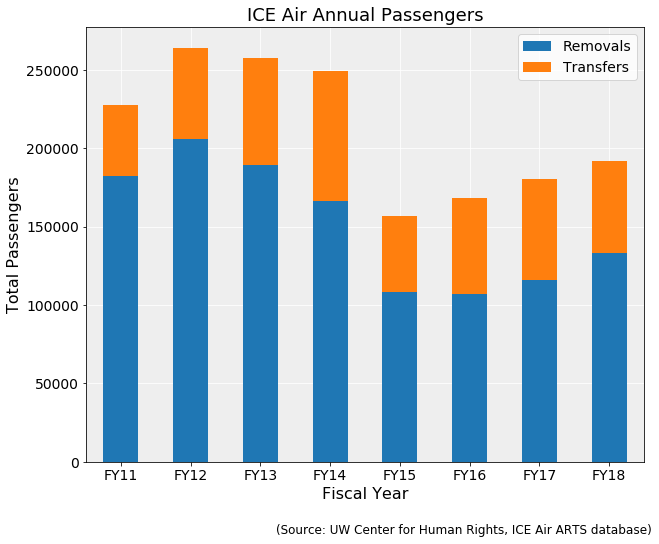

In [36]:
removal_transfer_bar(r_t_annual,
                     title=f'ICE Air Annual Passengers',
                     filename=f'annual_passengers_bar',
                     ylabel=f'Total Passengers',
                     xlabel='Fiscal Year');

# Charts of nationalities per year

## Top 5 per year

To look at removals or other variables by `CountryOfCitizenship` per fiscal year (excluding FY19), we will want to select most common values and sum the rest, in order to create a clean chart. Method below selects top 5 nationalities per year, and sums the rest as "ALL OTHERS".

This is slightly counterintuitive, for example it creates illusion of no Dominican Republic removals in FY17. Maybe better solution would be to display for each year any nationality that is in top 5 for any given year. Alternatively, we could just plot top 5 values, or include several more over a certain threshold. Or we could plot all values for nationalities which are in the top 5 for any year.

In [37]:
# Set DataFrame or subset to chart here. Remember to set name as well.
df_to_analyze = removal_df
df_to_analyze.name = removal_df.name

In [38]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [39]:
# Selecting only years for which we have full data (FY2011 - FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [40]:
removal_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
# removal_nationality_by_year.to_csv(f'../output/removal_nationality_by_year.csv')

In [41]:
removal_nationality_by_year

AlienMasterID                                            \
CountryOfCitizenship        BRAZIL CAMEROON CAPE VERDE CHINA COLOMBIA   CUBA   
FY                                                                             
2010-10-01                     1.0      2.0        4.0   6.0   1059.0   31.0   
2011-10-01                     NaN      1.0        NaN   NaN   1020.0   34.0   
2012-10-01                     NaN      NaN        NaN   NaN    943.0   16.0   
2013-10-01                     NaN      7.0        NaN   NaN    865.0    6.0   
2014-10-01                     NaN      9.0        NaN  16.0    847.0   16.0   
2015-10-01                     NaN      3.0        NaN   NaN    847.0   25.0   
2016-10-01                     NaN      5.0        NaN  47.0    795.0   53.0   
2017-10-01                     8.0     13.0        7.0  93.0    866.0  255.0   

                                                                     ...    \
CountryOfCitizenship DOMINICAN REPUBLIC ECUADOR EL SALVADOR  GHANA   ...     
FY                                                                   ...     
2010-10-01                       2343.0  1436.0     15817.0   17.0   ...     
2011-10-01                       2281.0  1593.0     18107.0   14.0   ...     
2012-10-01                       1849.0  1318.0     20178.0    NaN   ...     
2013-10-01                       1747.0  1377.0     26507.0    NaN   ...     
2014-10-01                       1552.0  1153.0     21378.0    NaN   ...     
2015-10-01                       1556.0   980.0     20089.0   17.0   ...     
2016-10-01                       1696.0   929.0     17970.0  172.0   ...     
2017-10-01                       1520.0  1036.0     14516.0  130.0   ...     

                                                                              \
CountryOfCitizenship MOROCCO SOUTH AFRICA ST. LUCIA BURKINA FASO SOUTH SUDAN   
FY                                                                             
2010-10-01               NaN          NaN       NaN          NaN         NaN   
2011-10-01               NaN          NaN       NaN          NaN         NaN   
2012-10-01               NaN          NaN       NaN          NaN         NaN   
2013-10-01               NaN          NaN       NaN          NaN         NaN   
2014-10-01               NaN          NaN       NaN          NaN         NaN   
2015-10-01               NaN          NaN       NaN          NaN         NaN   
2016-10-01               NaN          NaN       NaN          NaN         NaN   
2017-10-01               1.0          1.0       2.0          5.0        61.0   

                                                                         \
CountryOfCitizenship ANTIGUA & BARBUDA BURMA SAMOA UNITED ARAB EMIRATES   
FY                                                                        
2010-10-01                         NaN   NaN   NaN                  NaN   
2011-10-01                         NaN   NaN   NaN                  NaN   
2012-10-01                         NaN   NaN   NaN                  NaN   
2013-10-01                         NaN   NaN   NaN                  NaN   
2014-10-01                         NaN   NaN   NaN                  NaN   
2015-10-01                         NaN   NaN   NaN                  NaN   
2016-10-01                         NaN   NaN   NaN                  NaN   
2017-10-01                         3.0  33.0   6.0                  1.0   

                              
CountryOfCitizenship NAMIBIA  
FY                            
2010-10-01               NaN  
2011-10-01               NaN  
2012-10-01               NaN  
2013-10-01               NaN  
2014-10-01               NaN  
2015-10-01               NaN  
2016-10-01               NaN  
2017-10-01               2.0  

[8 rows x 126 columns]

In [42]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [43]:
# Note 0 values in this version of chart. Missing values are included in "ALL OTHERS" category.
top_5_data

CountryOfCitizenship,ALL OTHERS,DOMINICAN REPUBLIC,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,MEXICO
FY11,4965,2343,15817,30472,0,21069,107781
FY12,5449,2281,18107,38399,0,30815,110763
FY13,4867,1849,20178,47955,0,35759,78651
FY14,4712,1747,26507,54135,0,39825,39278
FY15,3951,1552,21378,32599,0,19613,29461
FY16,3881,1556,20089,32963,0,21311,27082
FY17,6306,0,17970,32198,5549,21241,32967
FY18,5973,1520,14516,48765,0,27777,34738


In [44]:
top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [45]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    plt.legend(fontsize=14)
    txt='(Source: UW Center for Human Rights, ICE Air ARTS database)'
    plt.figtext(0.65, 0, txt, wrap=True, horizontalalignment='center', fontsize=12)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

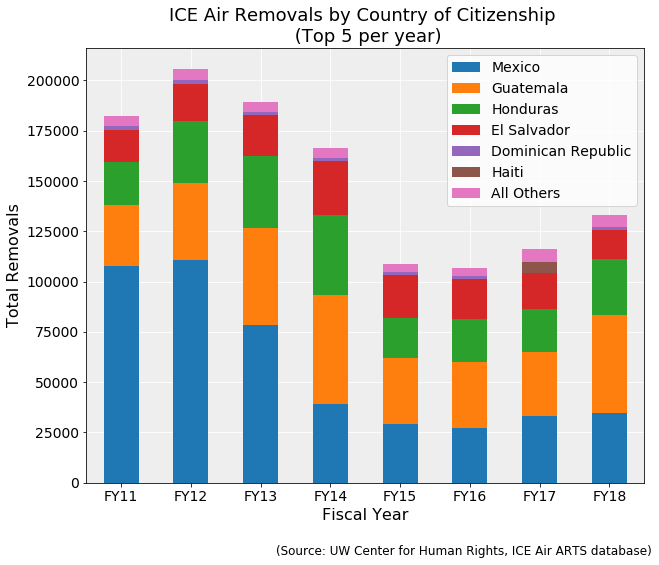

In [46]:
country_of_citizenship_trend(top_5_data,
                             title=f'ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'top5_total_deportation_nationalities_per_year',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

## Top 5 any year

Here's the alternate plot showing all nationalities which break the top 5 in any year. A bit messier, but outliers are still clear (El Salvador in FY14, Haiti in FY17, India in FY18), steady trends possibly clearer (Ecuador, Dominican Republic).

In [47]:
in_top_5 = list()
for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    in_top_5.extend(list(temp_top_5['CountryOfCitizenship']))

In [48]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [49]:
# Table for this version of chart is much better
top_5_data

Country of Citizenship,Mexico,Guatemala,Honduras,El Salvador,Dominican Republic,Haiti,All Others
FY11,107781,30472,21069,15817,2343,228,4737
FY12,110763,38399,30815,18107,2281,547,4902
FY13,78651,47955,35759,20178,1849,452,4415
FY14,39278,54135,39825,26507,1747,338,4374
FY15,29461,32599,19613,21378,1552,369,3582
FY16,27082,32963,21311,20089,1556,267,3614
FY17,32967,32198,21241,17970,1696,5549,4610
FY18,34738,48765,27777,14516,1520,805,5168


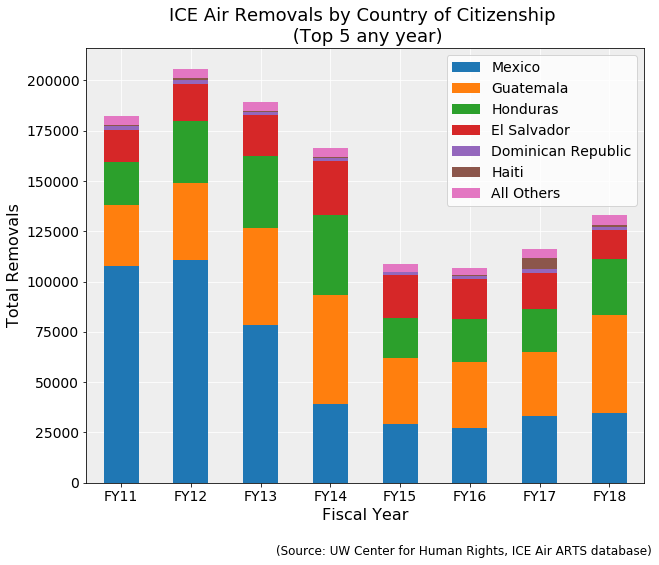

In [50]:
country_of_citizenship_trend(top_5_data,
                             title=f'ICE Air {df_to_analyze.name.title()} by Country of Citizenship \n (Top 5 any year)',
                             filename=f'top5_total_{df_to_analyze.name.lower()}_nationalities_any_year',
                             ylabel=f'Total {df_to_analyze.name.title()}',
                             xlabel='Fiscal Year');

In [51]:
cent_am = ['MEXICO', 'GUATEMALA', 'HONDURAS', 'EL SALVADOR']
cent_am = [i.title() for i in cent_am]
round((top_5_data[cent_am].sum(axis=1) / top_5_data.sum(axis=1)).mean() * 100)

95.0

In [52]:
top_5_data

Country of Citizenship,Mexico,Guatemala,Honduras,El Salvador,Dominican Republic,Haiti,All Others
FY11,107781,30472,21069,15817,2343,228,4737
FY12,110763,38399,30815,18107,2281,547,4902
FY13,78651,47955,35759,20178,1849,452,4415
FY14,39278,54135,39825,26507,1747,338,4374
FY15,29461,32599,19613,21378,1552,369,3582
FY16,27082,32963,21311,20089,1556,267,3614
FY17,32967,32198,21241,17970,1696,5549,4610
FY18,34738,48765,27777,14516,1520,805,5168


In [53]:
cent_am = ['MEXICO', 'GUATEMALA', 'HONDURAS', 'EL SALVADOR']

cent_am_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_cent_am = temp[temp['CountryOfCitizenship'].isin(list(set(cent_am)))]
    cent_am_count = sum(temp_cent_am['AlienMasterID'])
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(cent_am)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    temp_df = pd.DataFrame([['MX+GT+SV+HN', cent_am_count],
                            ['All Others', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year, year])
    cent_am_df = cent_am_df.append(temp_df)
    
cent_am_df.sort_index(inplace=True)
cent_am_df.index = [f'FY{str(x)[2:4]}' for x in cent_am_df.index.year + 1]

cent_am_data = pd.pivot_table(data=cent_am_df,
                       index=cent_am_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

cent_am_data = cent_am_data.reindex(cent_am_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(cent_am_data.columns)
cols.remove('All Others')
cols.append('All Others')
cent_am_data = cent_am_data[cols]
# cent_am_data.columns = cent_am_data.columns.str.title()
cent_am_data.columns.name = 'Country of Citizenship'

In [54]:
(cent_am_data.div(cent_am_data.sum(axis=1), axis=0) * 100).mean()

Country of Citizenship
MX+GT+SV+HN    94.853306
All Others      5.146694
dtype: float64

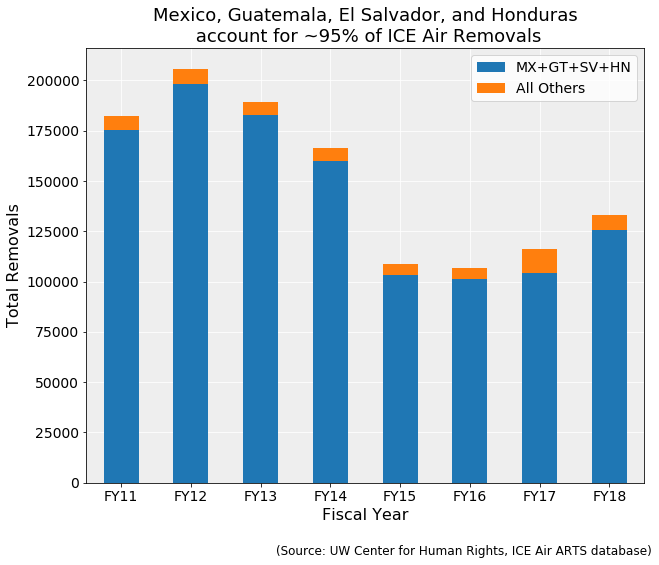

In [55]:
country_of_citizenship_trend(cent_am_data,
                             title=f'Mexico, Guatemala, El Salvador, and Honduras\n \
account for ~95% of ICE Air {df_to_analyze.name.title()}',
                             filename=f'cent_am_removals',
                             ylabel=f'Total {df_to_analyze.name.title()}',
                             xlabel='Fiscal Year');

In [56]:
sum(removal_df['CountryOfCitizenship'].isin(cent_am)) / len(removal_df) * 100

95.15062662491329

# Investigating other global variables

In [57]:
df['Juvenile'].value_counts(dropna=False)

False    1706578
True       26047
Name: Juvenile, dtype: int64

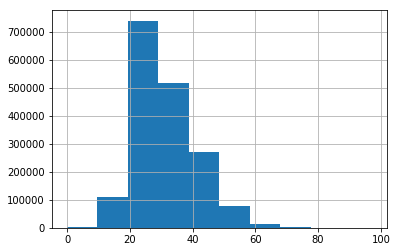

In [58]:
df['Age'].hist(bins=10)

In [59]:
df.groupby(['CountryOfCitizenship', 'R-T'])['Age'].mean()

CountryOfCitizenship            R-T
ALGERIA                         R      35.666668
                                T      36.555557
ARGENTINA                       R      43.214287
                                T      39.827587
ARMENIA                         T      33.634750
BANGLADESH                      R      33.669144
                                T      30.253986
BARBADOS                        R      42.500000
                                T      39.729168
BOLIVIA                         R      34.000000
                                T      35.036083
BOSNIA                          R      31.700001
                                T      31.839506
BRAZIL                          R      38.312500
                                T      33.468433
BRITISH VIRGIN ISLANDS          T      39.571430
BULGARIA                        R      31.000000
                                T      39.063492
CAMBODIA                        R      41.174999
                                T

In [60]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Age'].mean()

MissionDate
2010-10-01    31.539486
2011-10-01    31.316971
2012-10-01    30.838612
2013-10-01    29.555210
2014-10-01    31.360340
2015-10-01    31.364080
2016-10-01    32.182800
2017-10-01    31.831917
2018-10-01    30.838182
Freq: AS-OCT, Name: Age, dtype: float32

In [61]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Sex'].value_counts() / df.groupby([pd.Grouper(freq='AS-OCT')]).size() * 100

MissionDate  Sex
2010-10-01   M      94.388953
             F       5.608849
             U       0.002198
2011-10-01   M      94.875298
             F       5.112213
             U       0.012489
2012-10-01   M      93.725031
             F       6.263310
             U       0.011658
2013-10-01   M      86.789757
             F      13.193388
             U       0.016854
2014-10-01   M      89.255019
             F      10.738610
             U       0.005734
2015-10-01   M      90.129283
             F       9.870717
2016-10-01   M      90.430216
             F       9.563684
             U       0.006100
2017-10-01   M      92.114587
             F       7.883848
             U       0.001565
2018-10-01   M      92.010953
             F       7.989047
dtype: float64

# ICE total removal statistics

In [62]:
# Source: https://www.ice.gov/statistics
ice_ero_totals = [396906,
                  409849,
                  368644,
                  315943,
                  235413,
                  240255,
                  226119,
                  256086]

In [63]:
ice_total_comparison = pd.DataFrame({'ICE Air Removals': list(annual_removals['2010':'2017']), 'ICE ERO Total Removals': ice_ero_totals},
            index=annual_removals['2010':'2017'].index)

In [64]:
ice_total_comparison.sort_index(inplace=True)
ice_total_comparison.index = [f'FY{str(x)[2:4]}' for x in ice_total_comparison.index.year + 1]

In [65]:
ice_total_comparison['Percent'] = ice_total_comparison['ICE Air Removals'] / ice_total_comparison['ICE ERO Total Removals']

In [66]:
int(round((ice_total_comparison['Percent'] * 100).min()))

44

In [67]:
(ice_total_comparison['Percent'] * 100).max()

52.60569153296639

In [68]:
def ice_total_bar(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', legend=True, ax=ax).legend(bbox_to_anchor=(1,1))
    
    ax.set_axisbelow(True)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    plt.legend(fontsize=14)
    txt='(Source: UW Center for Human Rights, ICE Air ARTS database, ICE ERO)'
    plt.figtext(0.6, 0, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

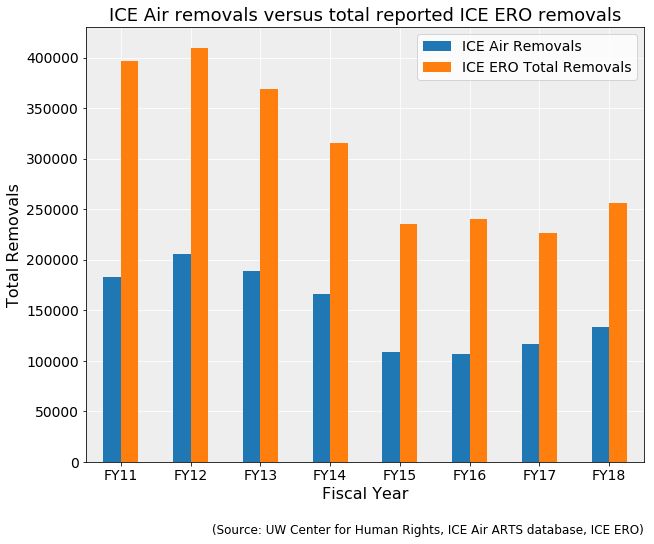

In [69]:
ice_total_bar(ice_total_comparison[['ICE Air Removals', 'ICE ERO Total Removals']],
                     title=f'ICE Air removals versus total reported ICE ERO removals',
                     filename=f'total_removals_comparison',
                     ylabel=f'Total Removals',
                     xlabel='Fiscal Year');

In [70]:
ice_ero_fy17_fy18 = pd.read_csv('../input/FY2017andFY2018ICERemovalsbyCountryofCitizenship.csv')

In [71]:
ice_ero_fy17_fy18['Source'] = 'ERO'

In [72]:
df.head()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionNumber,PULOC,DropLoc,StrikeFromList,...,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,NonCriminal
MissionDate,,,,,,,,,,,,,,,,,,,,,
2010-10-01,REMOVAL,M,Non-Criminal,No,1.0,18.0,110003,KIWA,MGGT,NaN,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,False
2010-10-01,REMOVAL,M,Non-Criminal,No,1.0,38.0,110003,KIWA,MGGT,NaN,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,False
2010-10-01,REMOVAL,M,Non-Criminal,No,1.0,20.0,110003,KIWA,MGGT,NaN,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,False
2010-10-01,REMOVAL,M,Non-Criminal,No,1.0,29.0,110003,KIWA,MGGT,NaN,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,False
2010-10-01,REMOVAL,M,Non-Criminal,No,1.0,21.0,110003,KIWA,MGGT,NaN,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,False


In [73]:
coc_removals_by_fy = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique()
coc_removals_by_fy = coc_removals_by_fy.reset_index()
coc_removals_by_fy['CountryOfCitizenship'] = coc_removals_by_fy['CountryOfCitizenship'].copy().astype(str)
coc_removals_by_fy.set_index('MissionDate', inplace=True)
coc_removals_by_fy = coc_removals_by_fy.loc['2016':'2017']
coc_removals_by_fy['FY'] = [f'20{str(x)[2:4]}' for x in coc_removals_by_fy.index.year + 1]
coc_removals_by_fy = coc_removals_by_fy.reset_index()
coc_removals_by_fy = coc_removals_by_fy.drop('MissionDate', axis=1)

In [74]:
coc_removals_by_fy.head()

,CountryOfCitizenship,AlienMasterID,FY
0,ALGERIA,3,2017
1,BANGLADESH,139,2017
2,BOSNIA,9,2017
3,CAMBODIA,28,2017
4,CAMEROON,5,2017


In [75]:
coc_removals_by_fy = coc_removals_by_fy.pivot(index='CountryOfCitizenship', columns='FY')

In [76]:
coc_removals_by_fy.columns = coc_removals_by_fy.columns.droplevel()

In [77]:
coc_removals_by_fy = coc_removals_by_fy.reset_index()

In [78]:
coc_removals_by_fy['Source'] = 'ARTS'

In [79]:
# coc_removals_by_fy.fillna(0, inplace=True)
# ice_ero_fy17_fy18.fillna(0, inplace=True)

In [80]:
coc_removals_by_fy.head()

FY,CountryOfCitizenship,2017,2018,Source
0,AFGHANISTAN,29.0,16.0,ARTS
1,ALGERIA,3.0,NaN,ARTS
2,ANTIGUA & BARBUDA,NaN,3.0,ARTS
3,ARGENTINA,NaN,7.0,ARTS
4,BAHAMAS,NaN,1.0,ARTS


In [81]:
ice_ero_fy17_fy18.head()

,CountryOfCitizenship,2017,2018,Source
0,MEXICO,128765,141045,ERO
1,GUATEMALA,33570,50390,ERO
2,HONDURAS,22381,28894,ERO
3,EL SALVADOR,18838,15445,ERO
4,DOMINICAN REPUBLIC,1986,1769,ERO


In [82]:
coc_removals_by_fy = coc_removals_by_fy.set_index(['CountryOfCitizenship', 'Source'])
ice_ero_fy17_fy18 = ice_ero_fy17_fy18.set_index(['CountryOfCitizenship', 'Source'])

In [83]:
# temp = coc_removals_by_fy.join(ice_ero_fy17_fy18, on='CountryOfCitizenship', how='outer', lsuffix='_ARTS', rsuffix='_ERO')
temp = pd.concat([coc_removals_by_fy, ice_ero_fy17_fy18])

In [84]:
temp = temp.reset_index()

In [85]:
temp = temp.groupby(['CountryOfCitizenship', 'Source']).sum()

In [86]:
table = temp.unstack().loc[['MEXICO', 'SOMALIA', 'CAMBODIA', 'CUBA', 'ERITREA']]

In [87]:
table = table.fillna('0')

In [88]:
table

FY                     2017             2018          
Source                 ARTS       ERO   ARTS       ERO
CountryOfCitizenship                                  
MEXICO                32967  128765.0  34738  141045.0
SOMALIA                 342     521.0    151     229.0
CAMBODIA                 28      29.0     90     110.0
CUBA                     53     160.0    255     463.0
ERITREA                   0      41.0      0      62.0

In [89]:
table.to_csv('../output/arts-ero-comparison-table.csv')

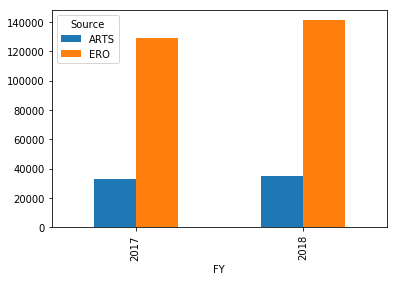

In [90]:
temp.loc['MEXICO'].T.plot(kind='bar')

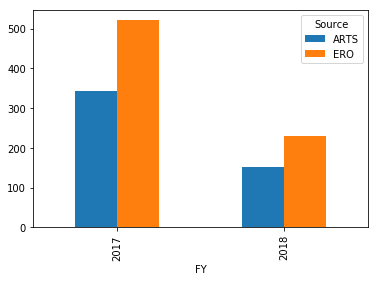

In [91]:
temp.loc['SOMALIA'].T.plot(kind='bar')

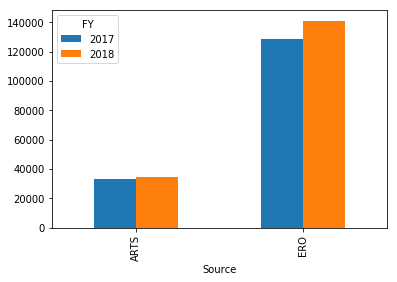

In [92]:
temp.loc['MEXICO'].plot(kind='bar')